# Plot results from evolutionary optimization

This notebook plots the results from the evolutionary optimization runs that were previously executed in another notebook. It loads the results that were saves as *.dill files and generates the plots from Fig. 3

In [2]:
# change into the root directory of the project
import os
if os.getcwd().split("/")[-1] == "notebooks":
    os.chdir('..')

In [3]:
import logging
logger = logging.getLogger()
#import warnings
#warnings.filterwarnings("ignore")

logger.setLevel(logging.INFO)
#logging.disable(logging.WARNING)
#logging.disable(logging.WARN)

%load_ext autoreload
%autoreload 2

In [ ]:
%aimport

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'plasma'
import scipy
import dill 

from neurolib.models.aln import ALNModel
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.evolution import Evolution
import neurolib.utils.functions as func
import neurolib.utils.devutils as du


import neurolib.optimize.evolution.evolutionaryUtils as eu
import neurolib.utils.brainplot as bp


from neurolib.utils.loadData import Dataset

In [6]:
ds = Dataset("gw")
model = ALNModel(Cmat = ds.Cmat, Dmat = ds.Dmat) # simulates the whole-brain model in 10s chunks by default if bold == True
# Resting state fits
model.params['dt'] = 0.1
model.params['duration'] = 5 * 60 * 1000 #ms
# testing: aln.params['duration'] = 0.2 * 60 * 1000 #ms
# real: aln.params['duration'] = 1.0 * 60 * 1000 #ms
model.params['save_dt'] = 10.0 # 10 ms sampling steps for saving data, should be multiple of dt
# structural values
model.params["Ke_gl"] = 300.0
model.params["signalV"] = 80.0

INFO:root:Loading dataset gw_big from /Users/caglar/Documents/PhD/projects/neurolib/neurolib/utils/../data/datasets/gw_big.
INFO:root:Dataset gw_big loaded.
INFO:root:aln: Model initialized.


In [7]:
plt.style.use("paper")
plt.style.reload_library()

In [8]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

In [9]:
# load EEG power spectrum
f_eeg, mean_eeg_power = dill.load(open("./data/mean_eeg_power_N3.dill", "rb"))

In [8]:
# initialize mock evolution for loading previously generated data
pars = ParameterSpace(['mock'], 
                      [[0, 1]])
evaluateSimulation = lambda x: x
evolutionAll = Evolution(evaluateSimulation, 
                      pars)
evolutionMedian = Evolution(evaluateSimulation, 
                      pars)
evolutionFmri = Evolution(evaluateSimulation, 
                      pars)
evolutionFmriAdapt = Evolution(evaluateSimulation, 
                      pars)

INFO:root:weightList not set, assuming single fitness value to be maximized.
INFO:root:Trajectory Name: results-2020-10-23-10H-03M-53S
INFO:root:Storing data to: ./data/hdf/evolution.hdf
INFO:root:Trajectory Name: results-2020-10-23-10H-03M-53S
INFO:root:Number of cores: 8
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evolution: Using algorithm: adaptive
MainProcess root INFO     Evolution: Individual generation: <function randomParametersAdaptive at 0x7fa5ed895d90>
MainProcess root INFO     Evolution: Mating operator: <function cxBlend at 0x7fa5ed3ea8c8>
MainProcess root INFO     Evolution: Mutation operator: <function gaussianAdaptiveMutation_nStepSizes at 0x7fa5ed8a6268>
MainProcess root INFO     Evolution: Parent selection: <function selRank at 0x7fa5ed895f28>
MainProcess root INFO     Evolution: Selection operator

In [9]:
# defines criteria for a good solution
def filter_per_objective(dfEvolution):
    if "f0" in dfEvolution:
        filtered_df = dfEvolution[dfEvolution.f0 > 0.35]
    if "f1" in filtered_df:
        filtered_df = filtered_df[filtered_df.f1 < 0.5] 
    if "f2" in filtered_df:
        filtered_df = filtered_df[filtered_df.f2 > 0.7] 
    return filtered_df

In [10]:
LOAD_OUTPUTS = False

In [11]:
EEG_EVOLUTION_ALL = "/Volumes/fastio/RESULTS/evolution/evolution-results-2020-09-25-18H-45M-00S.dill"

evolutionAll = evolutionAll.loadEvolution(EEG_EVOLUTION_ALL)
dfEvolutionAll = evolutionAll.dfEvolution(outputs=LOAD_OUTPUTS)
# for saving RAM, uncomment the following line(s)
#del(evolutionAll.history)

/Users/caglar/Documents/PhD/projects/neurolib/neurolib/optimize/evolution/evolution.py:859: UserWarning: Warning: converting a masked element to nan.
  scores = [float(p.fitness.score) for p in allIndividuals]


In [12]:
EEG_EVOLUTION_MEDIAN_KILLER = "/Volumes/fastio/RESULTS/evolution/evolution-results-2020-09-27-12H-23M-15S.dill"
evolutionMedian = evolutionMedian.loadEvolution(EEG_EVOLUTION_MEDIAN_KILLER)
dfEvolutionMedian = evolutionMedian.dfEvolution(outputs=LOAD_OUTPUTS)
#del(evolutionMedian.history)

In [14]:
FMRI_EVOLUTION = "/Volumes/fastio/RESULTS/evolution/evolution-results-2020-07-26-18H-06M-55S.dill"
evolutionFmri = evolutionFmri.loadEvolution(FMRI_EVOLUTION)
dfevolutionFmri = evolutionFmri.dfEvolution(outputs=LOAD_OUTPUTS)
#del(evolutionFmri.history)

In [15]:
FMRI_EVOLUTION_ADAPT = "/Volumes/fastio/RESULTS/evolution/evolution-results-2020-07-27-11H-49M-36S.dill"
evolutionFmriAdapt = evolutionFmriAdapt.loadEvolution(FMRI_EVOLUTION_ADAPT)
dfevolutionFmriAdapt = evolutionFmriAdapt.dfEvolution(outputs=LOAD_OUTPUTS)
#del(evolutionFmriAdapt.history)

In [19]:
print("Overall, there were this many individuals:")
print(f"There are {len(dfEvolutionAll)} *all* individuals")
print(f"There are {len(dfEvolutionMedian)} *mediankiller* individuals")
print(f"There are {len(dfevolutionFmri)} *fmri* individuals")
print(f"There are {len(dfevolutionFmriAdapt)} *fmri-adapt* individuals")

Overall, there were this many individuals:
There are 8000 *all* individuals
There are 8053 *mediankiller* individuals
There are 1600 *fmri* individuals
There are 1600 *fmri-adapt* individuals


In [20]:
# keep only good solutions
dfGoodAll = filter_per_objective(dfEvolutionAll)
dfGoodAll = dfGoodAll.sort_values('score', ascending=False)

dfGoodMedian = filter_per_objective(dfEvolutionMedian)
dfGoodMedian = dfGoodMedian.sort_values('score', ascending=False)

dfGoodFmri = filter_per_objective(dfevolutionFmri)
dfGoodFmri = dfGoodFmri.sort_values('score', ascending=False)

dfGoodFmriAdapt = filter_per_objective(dfevolutionFmriAdapt)
dfGoodFmriAdapt = dfGoodFmriAdapt.sort_values('score', ascending=False)

In [21]:
print("Before filtering out median rate")
print(f"There are {len(dfGoodAll)} GOOD *all* solutions")
print(f"There are {len(dfGoodMedian)} GOOD *mediankiller* solutions")
print(f"There are {len(dfGoodFmri)} GOOD *fmri* solutions")
print(f"There are {len(dfGoodFmriAdapt)} GOOD *fmri-adapt* solutions")

Before filtering out median rate
There are 2880 GOOD *all* solutions
There are 705 GOOD *mediankiller* solutions
There are 177 GOOD *fmri* solutions
There are 734 GOOD *fmri-adapt* solutions


In [22]:
if "median_rate" in dfGoodAll:
    print(f"{np.sum(dfGoodAll.median_rate<1)/len(dfGoodAll) * 100:.2f}% of *all* solutions have median<1")
    print(f"{np.sum(dfGoodMedian.median_rate>1)/len(dfGoodMedian) * 100:.2f}% of *mediankiller* solutions have median>1")

In [26]:
print(f"There are {len(dfGoodAll)} *all* solutions left after filtering")
print(f"There are {len(dfGoodMedian)} *mediankiller* solutions left after filtering")

There are 2880 *all* solutions left after filtering
There are 705 *mediankiller* solutions left after filtering


In [27]:
print(f"*all* best solution scores:")
print(f"FC: {dfGoodAll.iloc[0].f0}")
print(f"FCD: {dfGoodAll.iloc[0].f1}")
print(f"EEG: {dfGoodAll.iloc[0].f2}")

print(f"*mediankiller* best solution scores:")
print(f"FC: {dfGoodMedian.iloc[0].f0}")
print(f"FCD: {dfGoodMedian.iloc[0].f1}")
print(f"EEG: {dfGoodMedian.iloc[0].f2}")

print(f"*fmri* best solution scores:")
print(f"FC: {dfGoodFmri.iloc[0].f0}")
print(f"FCD: {dfGoodFmri.iloc[0].f1}")

print(f"*fmri-adapt* best solution scores:")
print(f"FC: {dfGoodFmriAdapt.iloc[0].f0}")
print(f"FCD: {dfGoodFmriAdapt.iloc[0].f1}")

*all* best solution scores:
FC: 0.566946115701087
FCD: 0.24915504219749504
EEG: 0.9677716885792021
*mediankiller* best solution scores:
FC: 0.5585464266517041
FCD: 0.2528170859538784
EEG: 0.9290639271589399
*fmri* best solution scores:
FC: 0.5674718430694058
FCD: 0.25828361017040263
*fmri-adapt* best solution scores:
FC: 0.5629339015903104
FCD: 0.26441434177283235


In [177]:
colors = {"mediankiller":"C0", "all":"C1", "fmri-adapt" : "C9", "fmri" : "C2"}

In [28]:
def plot_stats(model, name=None, savefigs=False):
    """Plot several different up-down-statistics.
    """
    bp.plot_rates(model)
    name = name or "noname"
    if name.startswith("mediankiller"):
        plot_col = "C0"
    elif name.startswith("all"):
        plot_col = "C1"
    elif name.startswith("fmri-adapt"):
        plot_col = "C9"        
    elif name.startswith("fmri"):
        plot_col = "C2"
    else:
        plot_col = "k"
    print(f"--------- {name} ---------")
    bp.plot_average_timeseries(model, xticks=True, kwargs={"c" : plot_col, "lw" : 2}, figsize=(4, 1), xlim=(0, 10))
    if savefigs:
        plt.savefig(f"./figures/assets/evolution/assets/simulations/mean_rate_{name}.pdf", transparent=True)
    
    print("plot_states_timeseries")
    states = bp.detectSWs(model)
    bp.plot_states_timeseries(model, states, title=None, labels=False)
    if savefigs:
        plt.savefig(f"./figures/assets/evolution/assets/simulations/states_{name}.pdf", transparent=True)
    
    print("plot_state_durations")
    bp.plot_state_durations(model, states, alpha=0.75)
    print("plot_down_up_durations")
    durations = bp.get_state_lengths(states)
    ups, downs = bp.get_updown_lengths(durations)
    bp.plot_down_up_durations(model, durations, ds)
    
    print("plot_involvement_distribution")
    involvement = bp.get_involvement(states)
    bp.plot_involvement_distribution(model, involvement)
    
    print("plot_degree_duration_scatterplot")
    bp.plot_degree_duration_scatterplot(model, states, ds, color_up="C0",  color_down="C1")
    print("plot_involvement_mean_amplitude")
    bp.plot_involvement_mean_amplitude(model, involvement, skip=1, lingress=True)    
    plt.tight_layout()
    plt.show()

# Plot individuals from history

Note: This might not work because above, we might have deleted the history (due to its huge memory consumption). In that case, resolt to the next section where we plot individuals from evolution.pop

In [29]:
def plot_individuals_of_evolution(evolution, dfPop, k = 10, name = None, savefigs=False):
    """Loops over all individuals in the dataframe, initializes the model from the parameters
    of each solution and then calls the plotting function.
    """
    for ki, (key, value) in enumerate(dfPop.iterrows()):
        print(key)
        if ki >= k:
            break
        # get the individual from the evolution
        #p=evolution.pop[key]
        #ind_params = dict(evolution.individualToDict(p))

        # get individual from Datadrame
        ind_params = dict(dfPop.iloc[ki])
        p = evolution.getIndividualFromHistory(ind_params['id'])

        # set model parameters to this individual
        model.params.update(ind_params)
        model.params['dt'] = model.params['save_dt']
        
        rate_len_dt = p.outputs['output'].shape[1]
        t_array = np.linspace(0, rate_len_dt * model.params['dt'], rate_len_dt)
        model.t = t_array
        
        model.outputs[model.default_output] = p.outputs['output']
        

        # plot
        print(p.fitness)
        print(p.outputs['median_rate'])

        plot_stats(model, name=name + "-" + str(key), savefigs=savefigs)    

In [ ]:
plot_individuals_of_evolution(evolutionAll, dfGoodAll, k=1, name="all", savefigs=False)

In [ ]:
plot_individuals_of_evolution(evolutionMedian, dfGoodMedian, k=10, name="mediankiller", savefigs=True)

In [ ]:
plot_individuals_of_evolution(evolutionFmri, dfGoodFmri, k=1, name="fmri", savefigs=True)

In [ ]:
plot_individuals_of_evolution(evolutionFmriAdapt, dfGoodFmriAdapt, k=5, name="fmri-adapt", savefigs=True)

# Plot individuals from evolution.pop

In [247]:
def plot_best_of_population(evolution, k=1, name="all", savefigs=False, plot_index = None):
    
    # if no index is give, sort the pop and plot them 
    if plot_index is None:
        plot_idxs = np.argsort([np.sum(p.fitness.wvalues) for p in evolution.pop])[::-1]
    else:
        # else: plot only specified examples
        plot_idxs = plot_index
        k = len(plot_idxs)
    
    for i in range(k):
        p = evolution.pop[plot_idxs[i]]
        ind_params = evolution.individualToDict(p)
        print("Model parameters:")
        print(ind_params)
        
        # set model parameters to this individual
        model.params.update(ind_params)
        model.params['dt'] = model.params['save_dt']
        
        rate_len_dt = p.outputs['output'].shape[1]
        t_array = np.linspace(0, rate_len_dt * model.params['dt'], rate_len_dt)
        model.t = t_array
        
        model.outputs[model.default_output] = p.outputs['output']
        

        # plot
        print(f"Weighted fitness vector: ({p.fitness.wvalues})")
        print(f"Median firing rate: {p.outputs['median_rate']}")

        plot_stats(model, name=name + "-" + str(plot_idxs[i]), savefigs=savefigs)    

In [ ]:
plot_best_of_population(evolutionAll, name="all", plot_index=[2], savefigs=True)

In [ ]:
plot_best_of_population(evolutionMedian, name="mediankiller", plot_index=[25], savefigs=True)

In [ ]:
plot_best_of_population(evolutionFmri, name="fmri", plot_index=[5], savefigs=True)

In [ ]:
plot_best_of_population(evolutionFmriAdapt, name="fmri-adapt", plot_index=[3], savefigs=True)

# Sleep model!

In [ ]:
plot_best_of_population(evolutionMedian, name="mediankiller", plot_index=[4, 25, 40, 44, 29, 9, 76])

In [282]:
dfGoodMedian[(dfGoodMedian.tauA<3800)&(dfGoodMedian.tauA>3400)&(dfGoodMedian.f1<0.3)]

,mue_ext_mean,mui_ext_mean,Ke_gl,b,tauA,sigma_ou,score,id,gen,f0,f1,f2
6261,3.343939,3.926673,273.538168,4.898111,3435.026164,0.371559,0.402074,6741,38,0.565656,0.254878,0.895444
6420,3.406377,3.947304,273.538168,4.898111,3435.026164,0.381108,0.387927,6900,39,0.561032,0.281398,0.884147
8012,3.343939,3.926673,273.538168,4.514877,3426.178759,0.365272,0.377345,8492,49,0.548619,0.247248,0.830664


In [ ]:
plt.scatter(dfGoodMedian.tauA, dfGoodMedian.b)

# Plot evolution results

In [151]:
plt.style.use("paper")
plt.style.reload_library()

In [153]:
dfGoodFmri[:100]

,mue_ext_mean,mui_ext_mean,Ke_gl,sigma_ou,score,id,gen,f0,f1
1422,0.670095,0.971642,382.534782,0.099169,0.154594,1662,17,0.567472,0.258284
921,0.565701,0.825391,356.817507,0.113168,0.151453,1161,11,0.554807,0.251902
1573,0.670045,0.971642,382.534782,0.099156,0.148889,1813,19,0.564149,0.266370
919,0.632495,0.944183,383.944080,0.099361,0.147317,1159,11,0.549895,0.255262
1238,0.668622,0.953599,383.101248,0.133489,0.145252,1478,15,0.566492,0.275987
...,...,...,...,...,...,...,...,...,...
1484,0.367260,0.753654,389.344977,0.169209,0.056702,1724,18,0.549507,0.436102
1200,0.959623,0.872012,370.802519,0.002852,0.056671,1440,15,0.468993,0.355650
733,0.928646,0.735095,354.283346,0.093254,0.055594,973,9,0.413973,0.302785
895,0.903816,0.892599,337.166733,0.114744,0.054787,1135,11,0.516973,0.407400


/Users/caglar/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/caglar/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


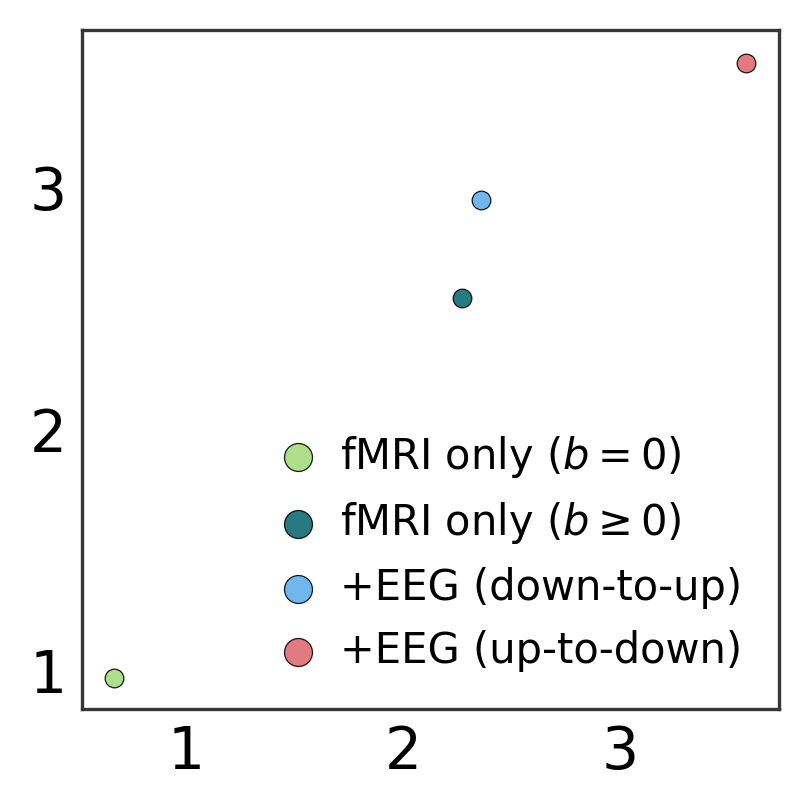

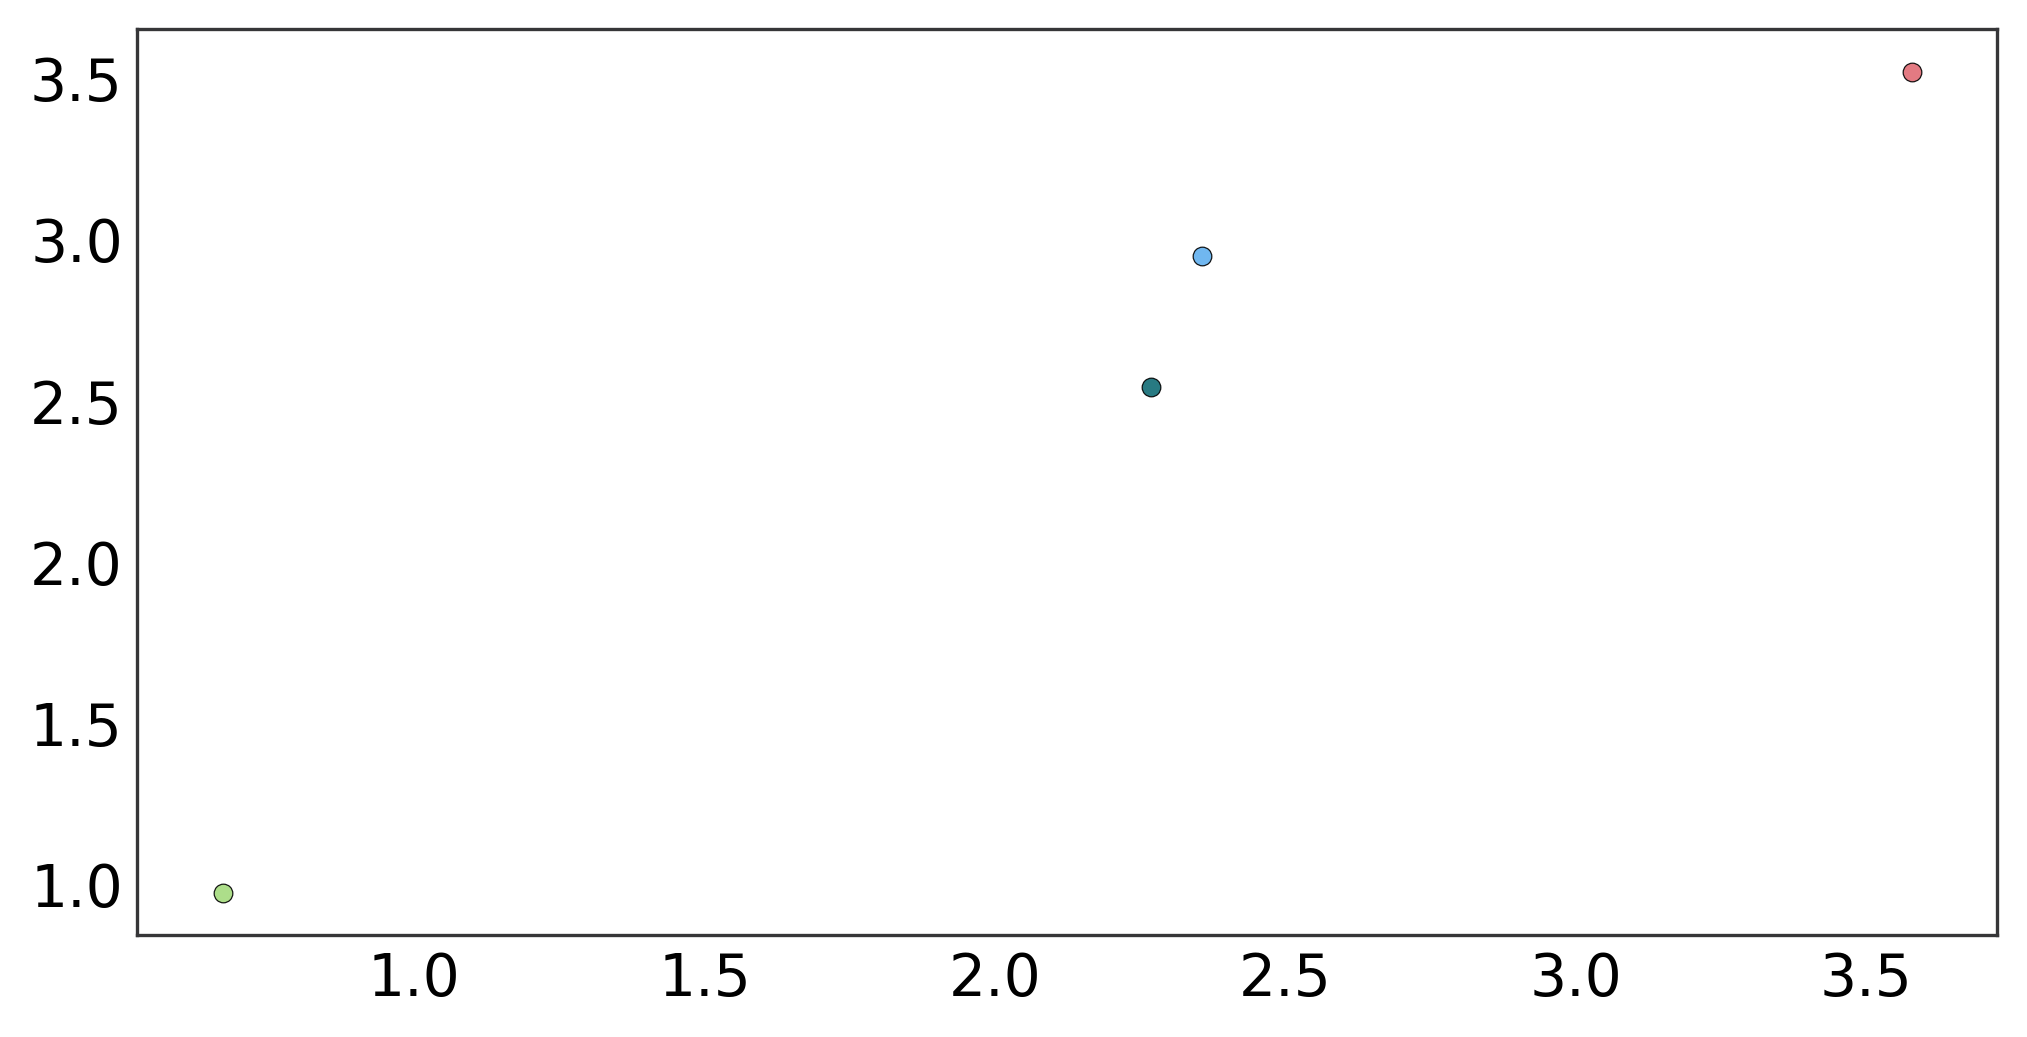

<Figure size 1350x300 with 0 Axes>

In [205]:
# only for legend!!!!
plt.figure(figsize=(3, 3))

n_points = 1
plt.scatter(dfGoodFmri[:n_points].mue_ext_mean, dfGoodFmri[:n_points].mui_ext_mean, s=20, label='fMRI only ($b=0$)', edgecolor='k', linewidth=0.3, alpha=0.9, c='C2', zorder=-2)
plt.scatter(dfGoodFmriAdapt[:n_points].mue_ext_mean, dfGoodFmriAdapt[:n_points].mui_ext_mean, s=20, label='fMRI only ($b\geq0$)', edgecolor='k', linewidth=0.3, alpha=0.9, c='C9', zorder=-2)
plt.scatter(dfGoodAll[:n_points].mue_ext_mean, dfGoodAll[:n_points].mui_ext_mean, s=20, label='+EEG (down-to-up)', edgecolor='k', linewidth=0.3, alpha=0.9, c='C1', zorder=-1)
plt.scatter(dfGoodMedian[:n_points].mue_ext_mean, dfGoodMedian[:n_points].mui_ext_mean, s=20, label='+EEG (up-to-down)', edgecolor='k', linewidth=0.3, alpha=0.9, c='C0', zorder=0)
leg = plt.legend(fontsize=10, frameon=False, markerscale=1.5, handletextpad=0)

import pylab
fig = pylab.figure()
figlegend = pylab.figure(figsize=(4.5,1.0))
ax = fig.add_subplot(111)
sc1 = ax.scatter(dfGoodFmri[:n_points].mue_ext_mean, dfGoodFmri[:n_points].mui_ext_mean, s=20, label='fMRI only ($b=0$)', edgecolor='k', linewidth=0.3, alpha=0.9, c='C2', zorder=-2)
sc2 = ax.scatter(dfGoodFmriAdapt[:n_points].mue_ext_mean, dfGoodFmriAdapt[:n_points].mui_ext_mean, s=20, label='fMRI only ($b\geq0$)', edgecolor='k', linewidth=0.3, alpha=0.9, c='C9', zorder=-2)
sc3 = ax.scatter(dfGoodAll[:n_points].mue_ext_mean, dfGoodAll[:n_points].mui_ext_mean, s=20, label='+EEG (down-to-up)', edgecolor='k', linewidth=0.3, alpha=0.9, c='C1', zorder=-1)
sc4 = ax.scatter(dfGoodMedian[:n_points].mue_ext_mean, dfGoodMedian[:n_points].mui_ext_mean, s=20, label='+EEG (up-to-down)', edgecolor='k', linewidth=0.3, alpha=0.9, c='C0', zorder=0)
scatters = [sc1, sc2, sc3, sc4]
labels = ['fMRI only ($b=0$)', 'fMRI only ($b\geq0$)', '+EEG (down-to-up)', '+EEG (up-to-down)']
figlegend.legend(scatters, labels, frameon=False, markerscale=1.5, handletextpad=-0.5, mode = "expand", ncol = 2)
#figlegend.legend(scatters, ('one', 'two', 'one', 'two'), 'center')
fig.show()

figlegend.show()
#figlegend.savefig("/Users/caglar/Documents/PhD/papers/2020-1-evolutionary-fitting/figures/assets/evolution/assets/fits_legend.pdf", transparent=True)

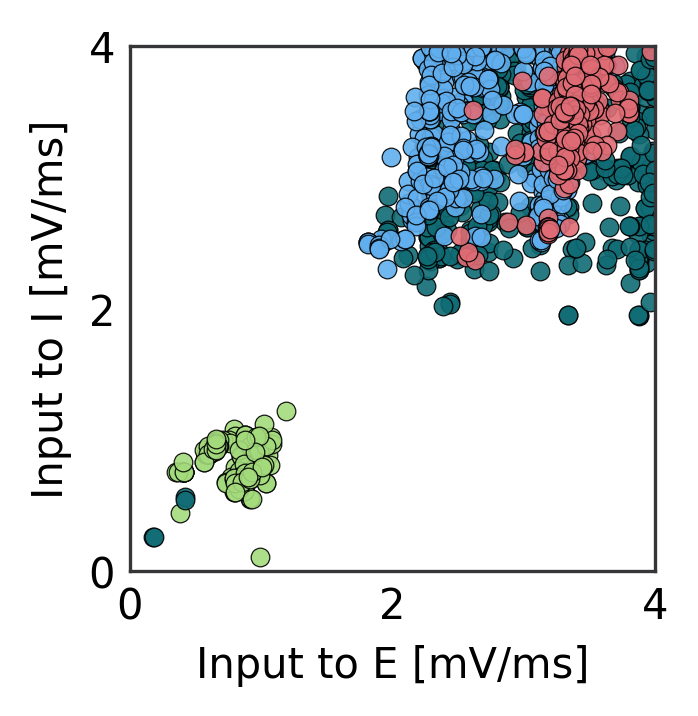

In [371]:
plt.figure(figsize=(3, 3))
n_points = 500
plt.scatter(dfGoodFmri[:n_points].mue_ext_mean, dfGoodFmri[:n_points].mui_ext_mean, s=20, label='fMRI-only fits', edgecolor='k', linewidth=0.3, alpha=0.9, c='C2', zorder=-2)
plt.scatter(dfGoodFmriAdapt[:n_points].mue_ext_mean, dfGoodFmriAdapt[:n_points].mui_ext_mean, s=20, edgecolor='k', linewidth=0.3, alpha=0.9, c='C9', zorder=-2)
plt.scatter(dfGoodAll[:n_points].mue_ext_mean, dfGoodAll[:n_points].mui_ext_mean, s=20, label='+EEG down-to-up', edgecolor='k', linewidth=0.3, alpha=0.9, c='C1', zorder=-1)
plt.scatter(dfGoodMedian[:n_points].mue_ext_mean, dfGoodMedian[:n_points].mui_ext_mean, s=20, label='+EEG up-to-down', edgecolor='k', linewidth=0.3, alpha=0.9, c='C0', zorder=0)
plt.xlim(0, 4)
plt.ylim(0, 4)
plt.yticks([0, 2, 4], fontsize=10)
plt.xticks([0, 2, 4], fontsize=10)
plt.xlabel("Input to E [mV/ms]", fontsize=10)
plt.ylabel("Input to I [mV/ms]", fontsize=10)
#plt.legend(fontsize=10, bbox_to_anchor=(0.94, 1.4), frameon=False, markerscale=1.5)
plt.tight_layout()
bp.set_axis_size(1.75, 1.75)
plt.savefig("/Users/caglar/Documents/PhD/papers/2020-1-evolutionary-fitting/figures/assets/evolution/assets/mue_mui_results.pdf", transparent=True)

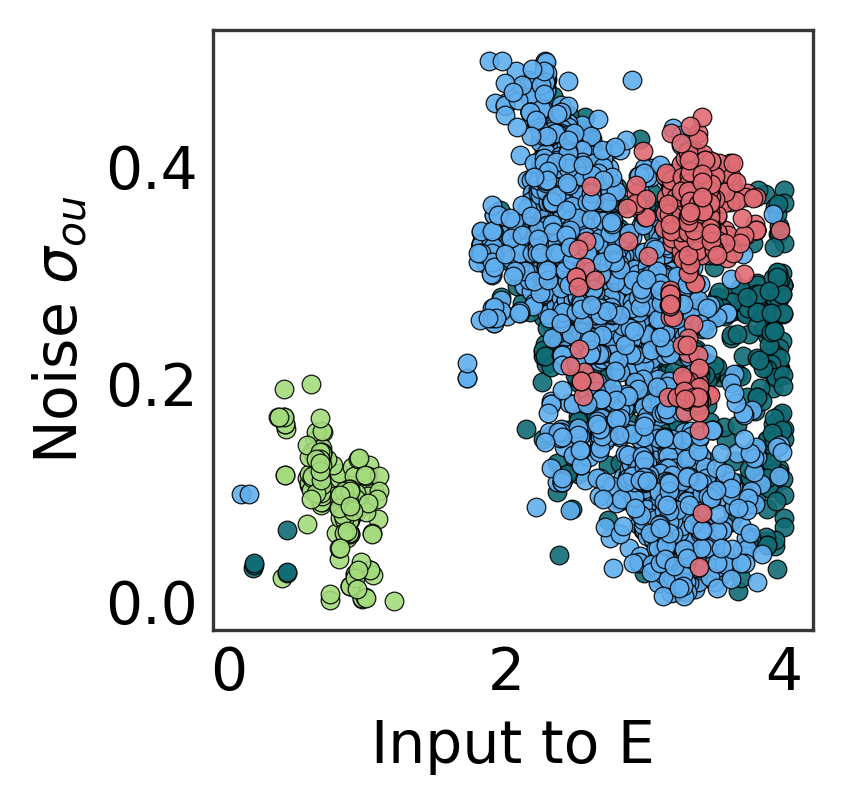

In [366]:
plt.figure(figsize=(3, 3))
plt.scatter(dfGoodAll.mue_ext_mean, dfGoodAll.sigma_ou, s=20, label='Down-to-up solution', edgecolor='k', linewidth=0.3, alpha=0.9, c='C1', zorder=-1)
plt.scatter(dfGoodMedian.mue_ext_mean, dfGoodMedian.sigma_ou, s=20, label='Up-to-down solutions', edgecolor='k', linewidth=0.3, alpha=0.9, c='C0', zorder=0)
plt.scatter(dfGoodFmri.mue_ext_mean, dfGoodFmri.sigma_ou, s=20, label='fMRI-only solutions', edgecolor='k', linewidth=0.3, alpha=0.9, c='C2', zorder=-2)
plt.scatter(dfGoodFmriAdapt.mue_ext_mean, dfGoodFmriAdapt.sigma_ou, s=20, label='fMRI-only fits', edgecolor='k', linewidth=0.3, alpha=0.9, c='C2', zorder=-2)
#plt.xlim(0, 4)
#plt.ylim(0, 4)
#plt.yticks([0, 2, 4])
plt.xlabel("Input to E")
plt.ylabel("Noise $\\sigma_{ou}$")
plt.tight_layout()
bp.set_axis_size(2, 2)
#plt.savefig("/Users/caglar/Documents/PhD/papers/2020-1-evolutionary-fitting/figures/assets/evolution/assets/mue_noise.pdf", transparent=True)

In [141]:
small_size = "o"
large_size = "s"

dfGoodAll.loc[dfGoodAll.median_rate>1, "median_scatter_marker"] = large_size
dfGoodAll.loc[dfGoodAll.median_rate<1, "median_scatter_marker"] = small_size

dfGoodMedian.loc[dfGoodMedian.median_rate>1, "median_scatter_marker"] = large_size
dfGoodMedian.loc[dfGoodMedian.median_rate<1, "median_scatter_marker"] = small_size

AttributeError: 'DataFrame' object has no attribute 'median_rate'

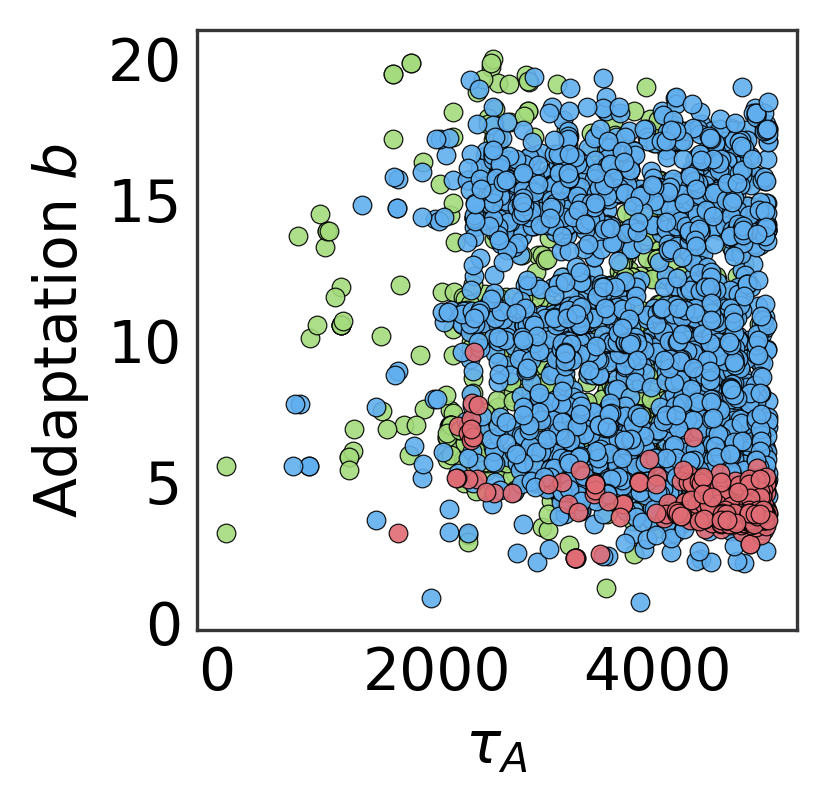

In [228]:
plt.figure(figsize=(3, 3))
plt.scatter(dfGoodAll.tauA, dfGoodAll.b, s=20, label='Down-to-up solution', edgecolor='k', linewidth=0.3, alpha=0.9, c='C1', zorder=-1)
plt.scatter(dfGoodMedian.tauA, dfGoodMedian.b, s=20, label='Up-to-down solutions', edgecolor='k', linewidth=0.3, alpha=0.9, c='C0', zorder=-0)
plt.scatter(dfGoodFmriAdapt.tauA, dfGoodFmriAdapt.b, s=20, label='fMRI - adapt', edgecolor='k', linewidth=0.3, alpha=0.9, c='C2', zorder=-2)

#plt.xlim(0, 4)
#plt.ylim(0, 4)
#plt.yticks([0, 2, 4])
plt.xlabel("$\\tau_A$")
plt.ylabel("Adaptation $b$")
plt.tight_layout()
bp.set_axis_size(2, 2)

In [221]:
# plt.figure(figsize=(3, 3))
# #plt.scatter(dfGoodFmri.b, dfGoodFmri.sigma_ou, s=20, label='fMRI-only fits', edgecolor='k', linewidth=0.3, alpha=0.9, c='C2', zorder=-2)
# plt.scatter(dfGoodFmriAdapt.b, dfGoodFmriAdapt.sigma_ou, s=20, edgecolor='k', label='fMRI-only fits', linewidth=0.3, alpha=0.9, c='C2', zorder=-2)
# plt.scatter(dfGoodAll.b, dfGoodAll.sigma_ou, s=20, label='+EEG down-to-up', edgecolor='k', linewidth=0.3, alpha=0.9, c='C1', zorder=-1)
# plt.scatter(dfGoodMedian.b, dfGoodMedian.sigma_ou, s=20, label='+EEG up-to-down', edgecolor='k', linewidth=0.3, alpha=0.9, c='C0', zorder=0)

# plt.xlabel("Adaptation $b$")
# plt.ylabel("Noise $\\sigma_{ou}$")
# plt.legend(fontsize=10, bbox_to_anchor=(0.95, 1.4), frameon=False, markerscale=2)
# plt.tight_layout()
# bp.set_axis_size(2, 2)
# plt.savefig("/Users/caglar/Documents/PhD/papers/2020-1-evolutionary-fitting/figures/assets/evolution/assets/adaptation_noise_results.pdf", transparent=True)

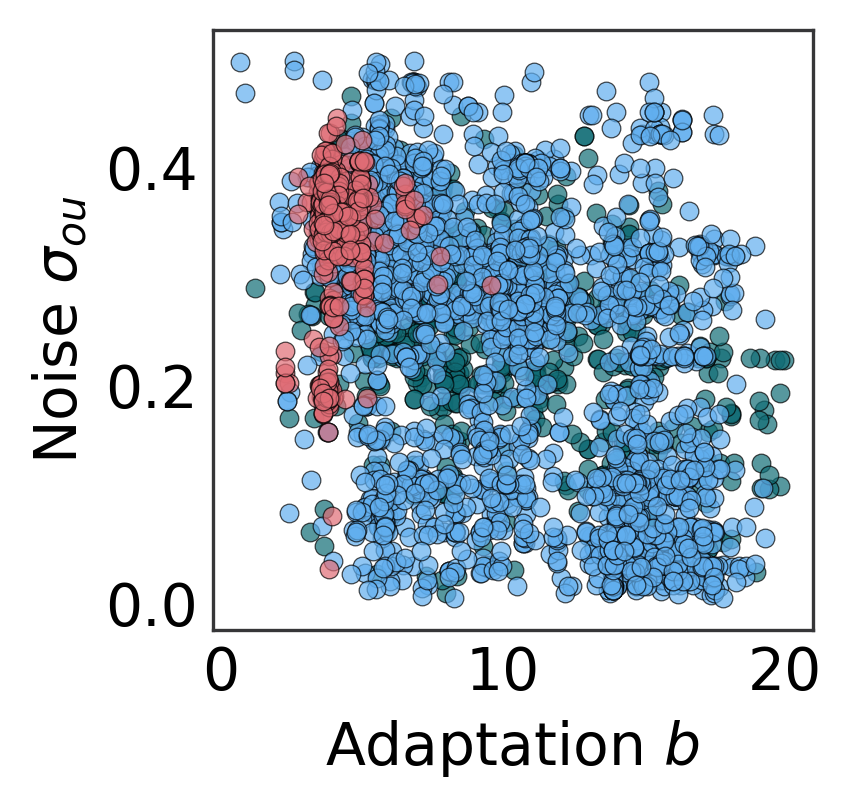

In [222]:
plt.figure(figsize=(3, 2.7))
plt.scatter(dfGoodAll.b, dfGoodAll.sigma_ou, s=20, label='Down-to-up solution', edgecolor='k', linewidth=0.3, alpha=0.7, c='C1', zorder=-1)
plt.scatter(dfGoodMedian.b, dfGoodMedian.sigma_ou, s=20, label='Up-to-down solutions', edgecolor='k', linewidth=0.3, alpha=0.7, c='C0', zorder=0)
plt.scatter(dfGoodFmriAdapt.b, dfGoodFmriAdapt.sigma_ou, s=20, label='fMRI - adapt', edgecolor='k', linewidth=0.3, alpha=0.7, c='C9', zorder=-2)


#plt.xlim(0, 4)
#plt.ylim(0, 4)
#plt.yticks([0, 2, 4])
plt.xlabel("Adaptation $b$")
plt.ylabel("Noise $\\sigma_{ou}$")
plt.tight_layout()
bp.set_axis_size(2, 2)

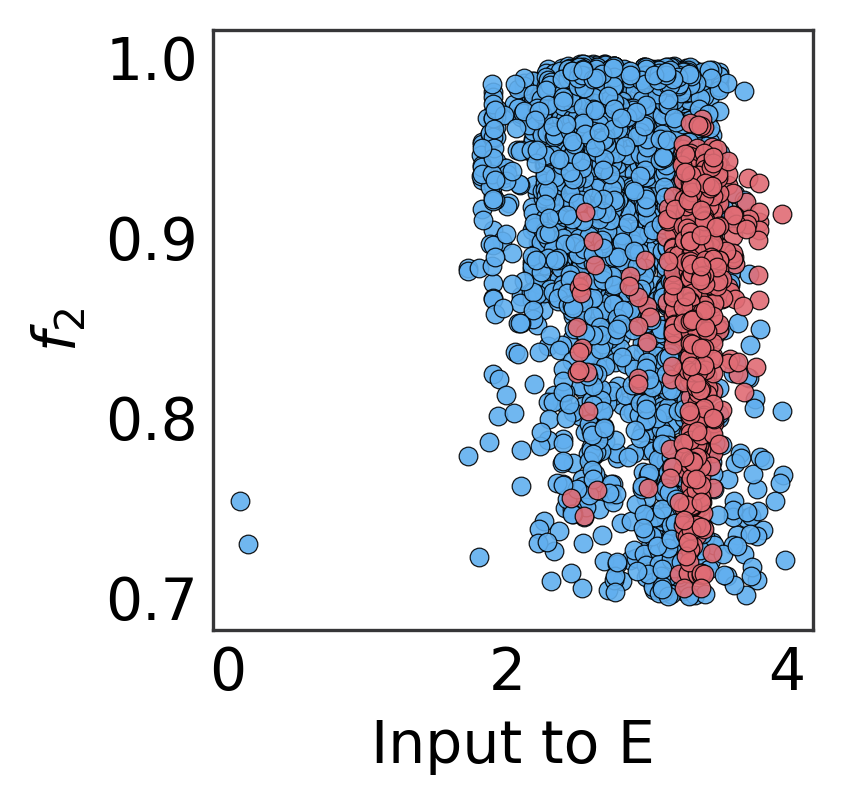

In [224]:
plt.figure(figsize=(3, 2.7))
plt.scatter(dfGoodAll.mue_ext_mean, dfGoodAll.f2, s=20, label='Down-to-up solution', edgecolor='k', linewidth=0.3, alpha=0.9, c='C1')
plt.scatter(dfGoodMedian.mue_ext_mean, dfGoodMedian.f2, s=20, label='Up-to-down solutions', edgecolor='k', linewidth=0.3, alpha=0.9, c='C0')

#plt.xlim(0, 4)
#plt.ylim(0, 4)
#plt.yticks([0, 2, 4])
plt.xlabel("Input to E")
plt.ylabel("$f_2$")
plt.tight_layout()
bp.set_axis_size(2, 2)

# Parameter distributions

In [31]:
def plot_evolution_histogram(key, label=None, savename=None, ylabel=False, xticks=None, normalize=True):
    hist_alpha = 0.655
    line_width = 1.0
    plt.figure(figsize=(2, 1.75))
    n, bins, rects = plt.hist(dfGoodAll[key], edgecolor='k', alpha=hist_alpha, linewidth=line_width, facecolor='C1', zorder=-2)
    if normalize:
        # iterate through rectangles, change the height of each
        for r in rects:
            r.set_height(r.get_height()/np.max(n))
    
    n, bins, rects = plt.hist(dfGoodMedian[key], alpha=hist_alpha, edgecolor='k', linewidth=line_width, facecolor='C0', zorder=-1)
    if normalize:
        for r in rects:
            r.set_height(r.get_height()/np.max(n))
            plt.ylim(0, 1.1)
    
    if key in dfGoodFmri:
        n, bins, rects = plt.hist(dfGoodFmri[key], alpha=hist_alpha, edgecolor='k', linewidth=line_width, facecolor='C2', zorder=-3)
        if normalize:
            for r in rects:
                r.set_height(r.get_height()/np.max(n))
                plt.ylim(0, 1.1)    
                
    if key in dfGoodFmriAdapt:
        n, bins, rects = plt.hist(dfGoodFmriAdapt[key], alpha=0.75, edgecolor='k', linewidth=0.75, color='C2', zorder=-3)
        if normalize:
            for r in rects:
                r.set_height(r.get_height()/np.max(n))
                plt.ylim(0, 1.1)                    
    
    plt.yticks([])

    if xticks:
        plt.xticks(xticks)
    
    if ylabel:
        plt.ylabel("Density")
    if label:
        plt.xlabel(label)
        
    plt.tight_layout()
    
    bp.set_axis_size(1.5, 1)
    
    if savename:
        plt.savefig(f"/Users/caglar/Documents/PhD/papers/2020-1-evolutionary-fitting/figures/assets/evolution/assets/{savename}", transparent=True)

In [335]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def plot_evolution_violin(key, label=None, savename=None, ylabel=False, xticks=None, fillna=False, bunchfMRI=False):
    figsize = (2.5, 2)
    figscale = 1.1
    colors = ["C0", "C1", "C2", "C9"]
    if bunchfMRI:
        names = ["Mediankiller", "All", "fMRI (bunched)"]
        dfs = [dfGoodMedian, dfGoodAll, dfGoodFmri.append(dfGoodFmriAdapt)]
    else:
        names = ["Mediankiller", "All", "fMRI (b=0)", "fMRI (b>0)"]
        dfs = [dfGoodMedian, dfGoodAll, dfGoodFmri, dfGoodFmriAdapt]
    
    # filtered indices
    indices = [i for i in range(len(dfs)) if key in dfs[i]]
    print(indices)
    # only if variable in this run
    #dfs = [df for df in dfs if key in df]
    dfs = [dfs[i] for i in indices]
    colors = [colors[i] for i in indices]
    #colors = ["C0", "C1", "C2", "C9"]
    
    plt.figure(figsize=(2.5, 2))
    medians = []
    maxs = []
    mins = []
    
    for i, df in enumerate(dfs):
        if fillna:
            data = df[key].fillna(0).values
        else:
            data = df[key].dropna().values
            
        parts = plt.violinplot(data, [i], vert=False,  showmeans=False, showextrema=False, showmedians=False)
        
        for pc in parts['bodies']:
            pc.set_facecolor(colors[i])
            pc.set_edgecolor('black')
            pc.set_alpha(1)
        
        quartile1, median, quartile3 = np.percentile(data, [25, 50, 75])
        whiskers = np.array(adjacent_values(data, quartile1, quartile3))
        whiskers_min, whiskers_max = whiskers[0], whiskers[1]
        
        medians.append(median)
        maxs.append(np.max(data))
        mins.append(np.min(data))
        
        #inds = np.arange(1, len(median) + 1)
        plt.scatter(median, i, marker='o', color='k', s=4, zorder=3)
        #plt.hlines(i, quartile1, quartile3, color='k', linestyle='-', lw=5)
        #plt.hlines(i, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

        plt.gca().tick_params(
            axis="x",
            direction="out",
            bottom=True,
        )
        
    plt.yticks([])
    if xticks:
        plt.xticks(xticks)
    
    if ylabel:
        plt.ylabel("Density")
    if label:
        plt.xlabel(label)
        
    plt.tight_layout()
    bp.set_axis_size(1.5*figscale, 1*figscale)
    
    # print stats
    print("Medians:", *zip(names, medians))
    print("Maximums:", *zip(names, maxs))
    print("Minimums:", *zip(names, mins))
    
    if savename:
        plt.savefig(f"/Users/caglar/Documents/PhD/papers/2020-1-evolutionary-fitting/figures/assets/evolution/assets/{savename}", transparent=True)

In [336]:
#plot_evolution_histogram(key="f0", label="FC corr.", savename="fc_correlations.pdf")

[0, 1, 2, 3]
Medians: ('Mediankiller', 0.5490414089739019) ('All', 0.5161832714133687) ('fMRI (b=0)', 0.5053447891676373) ('fMRI (b>0)', 0.5264666258074127)
Maximums: ('Mediankiller', 0.5750277394028355) ('All', 0.579988193987124) ('fMRI (b=0)', 0.5689553264852868) ('fMRI (b>0)', 0.5785410356577845)
Minimums: ('Mediankiller', 0.3864464501133308) ('All', 0.3501378304347638) ('fMRI (b=0)', 0.36064544241174135) ('fMRI (b>0)', 0.35619651047683615)


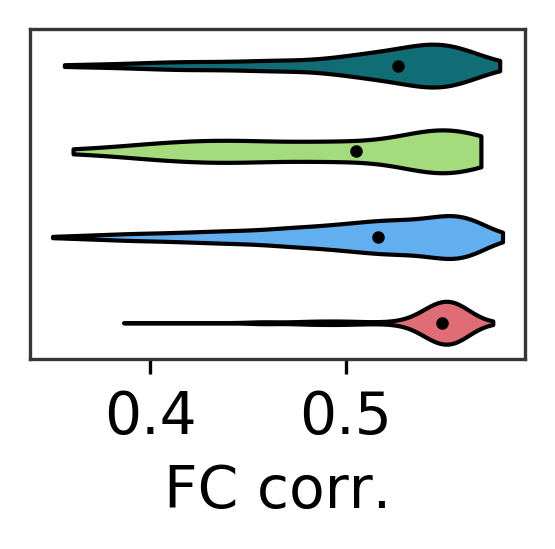

In [337]:
plot_evolution_violin("f0", label="FC corr.", savename="fc_correlations.pdf")

In [338]:
# plt.figure(figsize=(2, 1.75))
# plt.hist(dfGoodAll.f0, density=True, edgecolor='k', linewidth=0.75, color='C1')
# plt.hist(dfGoodMedian.f0, density=True, alpha=0.75, edgecolor='k', linewidth=0.75, color='C0')
# plt.yticks([])
# #plt.xticks([2, 3, 4])
# plt.ylabel("Density")
# plt.xlabel("FC corr.")
# plt.tight_layout()
# bp.set_axis_size(1.5, 1)

In [339]:
#plot_evolution_histogram(key="f1", label="FCD distance", savename="fcd_distances.pdf")

[0, 1, 2, 3]
Medians: ('Mediankiller', 0.3554880261248186) ('All', 0.3481281580927807) ('fMRI (b=0)', 0.3563487743912272) ('fMRI (b>0)', 0.3538469937644466)
Maximums: ('Mediankiller', 0.49933310487555777) ('All', 0.49982092941998596) ('fMRI (b=0)', 0.49538011342256627) ('fMRI (b>0)', 0.49991802397462776)
Minimums: ('Mediankiller', 0.2440765602322206) ('All', 0.24310628662043754) ('fMRI (b=0)', 0.2519022469494168) ('fMRI (b>0)', 0.24417365478686234)


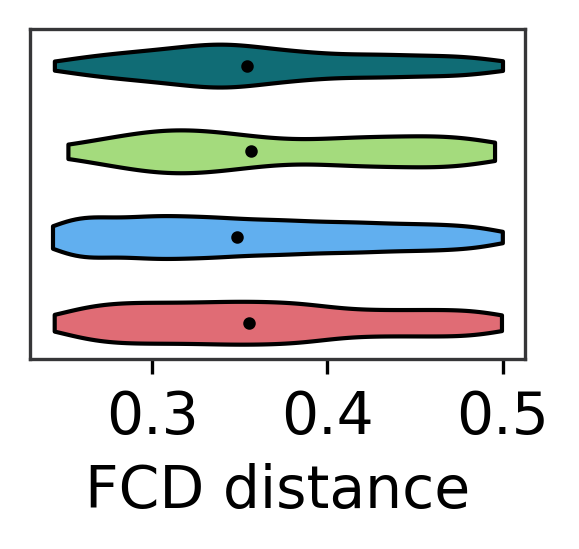

In [340]:
plot_evolution_violin(key="f1", label="FCD distance", savename="fcd_distances.pdf")

In [341]:
# plt.figure(figsize=(2, 1.75))
# plt.hist(dfGoodAll.f1, density=True, edgecolor='k', linewidth=0.75, color='C1')
# plt.hist(dfGoodMedian.f1, density=True, alpha=0.75, edgecolor='k', linewidth=0.75, color='C0')
# plt.yticks([])
# #plt.xticks([2, 3, 4])
# plt.ylabel("Density")
# plt.xlabel("FCD distance")
# plt.tight_layout()
# bp.set_axis_size(1.5, 1)

In [342]:
#plot_evolution_histogram(key="f2", label="EEG PS corr.", savename="fc_correlations.pdf")

[0, 1]
Medians: ('Mediankiller', 0.8837325209832742) ('All', 0.9465575990473832)
Maximums: ('Mediankiller', 0.9657667231841481) ('All', 0.9962958759031169)
Minimums: ('Mediankiller', 0.7052185189760167) ('All', 0.7008937035769428)


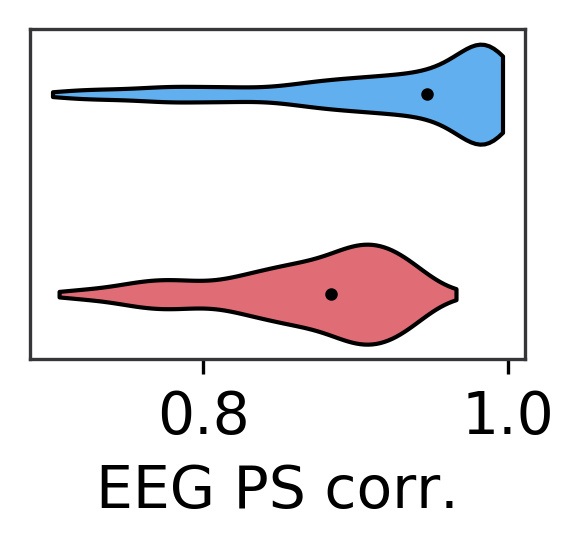

In [343]:
plot_evolution_violin("f2", label="EEG PS corr.", savename="eeg_correlations.pdf")

In [344]:
# plt.figure(figsize=(2, 1.75))
# plt.hist(dfGoodAll.f2, density=True, edgecolor='k', linewidth=0.75, color='C1')
# plt.hist(dfGoodMedian.f2, density=True, alpha=0.75, edgecolor='k', linewidth=0.75, color='C0')
# plt.yticks([])
# #plt.xticks([2, 3, 4])
# plt.ylabel("Density")
# plt.xlabel("EEG PS corr.")
# plt.tight_layout()
# bp.set_axis_size(1.5, 1)

In [345]:
#plot_evolution_histogram(key="mue_ext_mean", label="Input to E", xticks=[0, 2, 4], savename="mue_distribution_eeg_mediankiller.pdf")

[0, 1, 2, 3]
Medians: ('Mediankiller', 3.359792361650677) ('All', 2.731246665256235) ('fMRI (b=0)', 0.797950682146583) ('fMRI (b>0)', 2.845370066604376)
Maximums: ('Mediankiller', 3.9700251110443987) ('All', 3.988476242325082) ('fMRI (b=0)', 1.1900017674356107) ('fMRI (b>0)', 3.9998971220559016)
Minimums: ('Mediankiller', 2.4576137272516276) ('All', 0.08888361710834691) ('fMRI (b=0)', 0.35572654225971323) ('fMRI (b>0)', 0.17457209273530472)


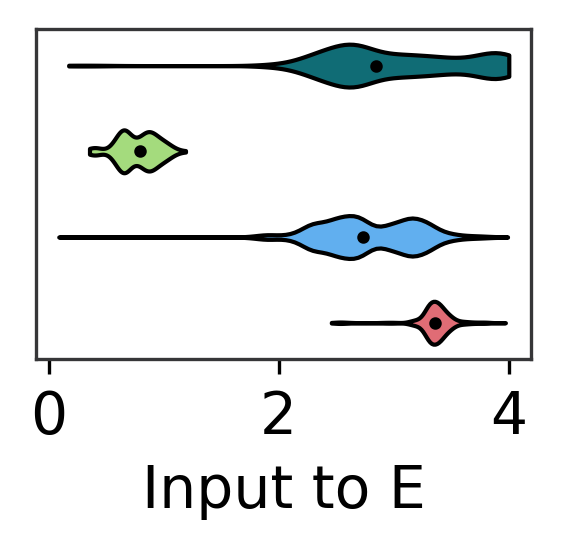

In [346]:
plot_evolution_violin(key="mue_ext_mean", label="Input to E", xticks=[0, 2, 4], savename="mue_distribution.pdf")

In [347]:
# plt.figure(figsize=(2, 1.75))
# plt.hist(dfGoodAll.mue_ext_mean, density=True, edgecolor='k', linewidth=0.75, color='C1')
# plt.hist(dfGoodMedian.mue_ext_mean, density=True, alpha=0.75, edgecolor='k', linewidth=0.75, color='C0')
# plt.yticks([])
# plt.xticks([2, 3, 4])
# plt.ylabel("Density")
# plt.xlabel("Input to E")
# plt.tight_layout()
# bp.set_axis_size(1.5, 1)
# plt.savefig("/Users/caglar/Documents/PhD/papers/2020-1-evolutionary-fitting/figures/assets/evolution/assets/mue_distribution_eeg_mediankiller.pdf", transparent=True)

In [348]:
#plot_evolution_histogram(key="mui_ext_mean", label="Input to I", xticks=[0, 2, 4], savename="mui_distribution.pdf")

[0, 1, 2, 3]
Medians: ('Mediankiller', 3.5292328095084096) ('All', 3.346519509135412) ('fMRI (b=0)', 0.8914225052189572) ('fMRI (b>0)', 3.1995287498709555)
Maximums: ('Mediankiller', 3.997926412602) ('All', 3.9998530816938875) ('fMRI (b=0)', 1.2192811785173172) ('fMRI (b>0)', 3.999431109643786)
Minimums: ('Mediankiller', 2.0255867125098326) ('All', 0.1572146056310233) ('fMRI (b=0)', 0.10739783547799597) ('fMRI (b>0)', 0.2538405178855849)


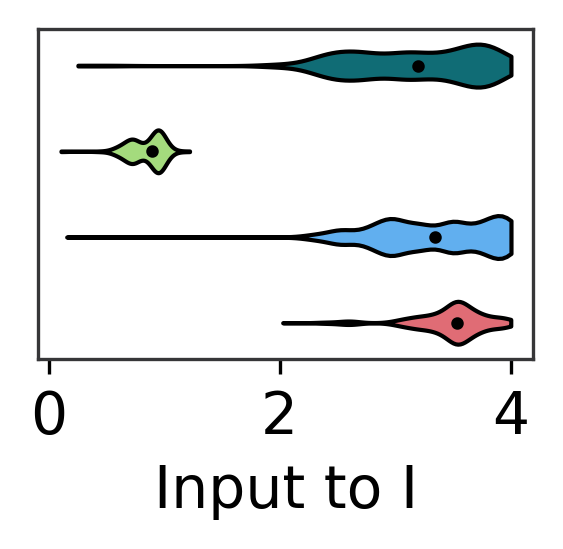

In [349]:
plot_evolution_violin(key="mui_ext_mean", label="Input to I", xticks=[0, 2, 4], savename="mui_distribution.pdf")

In [350]:
# plt.figure(figsize=(2, 1.75))
# plt.hist(dfGoodAll.mui_ext_mean, density=True, edgecolor='k', linewidth=0.75, color='C1')
# plt.hist(dfGoodMedian.mui_ext_mean, density=True, alpha=0.75, edgecolor='k', linewidth=0.75, color='C0')
# plt.yticks([])
# plt.xticks([2, 3, 4])
# plt.ylabel("Density")
# plt.xlabel("Input to I")
# plt.tight_layout()
# bp.set_axis_size(1.5, 1)
# plt.savefig("/Users/caglar/Documents/PhD/papers/2020-1-evolutionary-fitting/figures/assets/evolution/assets/mui_distribution_eeg_mediankiller.pdf", transparent=True)

In [351]:
#plot_evolution_histogram(key="sigma_ou", label="Noise $\\sigma_{ou}$", xticks=[0, 0.2, 0.4], savename="sigma_distribution_eeg_mediankiller.pdf")

[0, 1, 2, 3]
Medians: ('Mediankiller', 0.3601857491476283) ('All', 0.26975168010475326) ('fMRI (b=0)', 0.09942984041632957) ('fMRI (b>0)', 0.26363930681995257)
Maximums: ('Mediankiller', 0.44544028592437607) ('All', 0.49731938419601435) ('fMRI (b=0)', 0.19983604013352427) ('fMRI (b>0)', 0.4650279753338214)
Minimums: ('Mediankiller', 0.0312546701150295) ('All', 0.004646162550785621) ('fMRI (b=0)', 0.00036148880762082447) ('fMRI (b>0)', 0.00957309894903266)


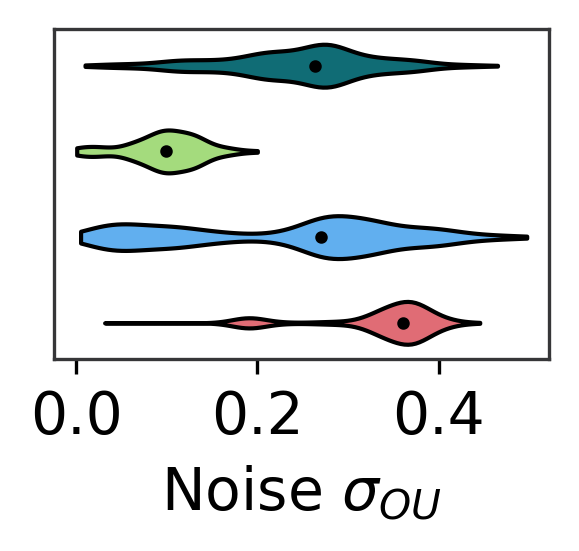

In [352]:
plot_evolution_violin(key="sigma_ou", label="Noise $\\sigma_{OU}$", xticks=[0, 0.2, 0.4], savename="sigma_distribution_eeg_mediankiller.pdf")

In [353]:
# plt.figure(figsize=(2, 1.75))
# plt.hist(dfGoodAll.sigma_ou, density=True, edgecolor='k', linewidth=0.75, color='C1')
# plt.hist(dfGoodMedian.sigma_ou, density=True, alpha=0.75, edgecolor='k', linewidth=0.75, color='C0')
# plt.yticks([])
# plt.xticks([0, 0.2, 0.4])
# #plt.ylabel("Density")
# plt.xlabel("Noise $\\sigma_{ou}$")
# plt.tight_layout()
# bp.set_axis_size(1.5, 1)
# plt.savefig("/Users/caglar/Documents/PhD/papers/2020-1-evolutionary-fitting/figures/assets/evolution/assets/sigma_distribution_eeg_mediankiller.pdf", transparent=True)

In [354]:
#plot_evolution_histogram(key="b", label="Adaptation $b$", xticks=[0, 10, 20], savename="b_distribution_eeg_mediankiller.pdf")

[0, 1, 3]
Medians: ('Mediankiller', 3.8222611562283944) ('All', 9.91418004482719) ('fMRI (b=0)', 9.355225311125853)
Maximums: ('Mediankiller', 9.576919193390168) ('All', 19.31702610824989) ('fMRI (b=0)', 19.966352095721533)
Minimums: ('Mediankiller', 2.2767475264029335) ('All', 0.6877028943263057) ('fMRI (b=0)', 1.2089714197225083)


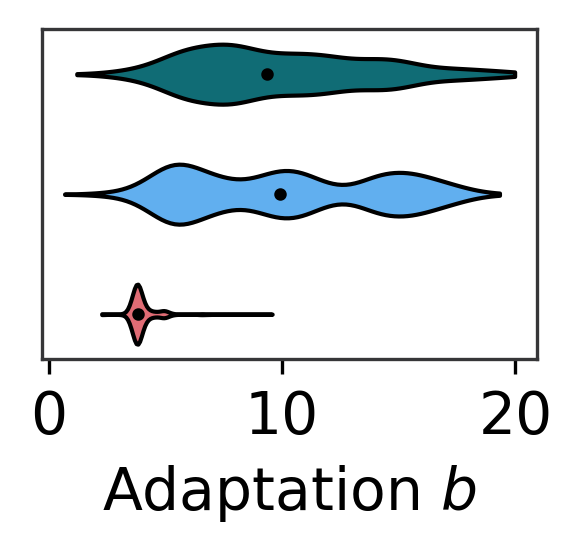

In [355]:
# need to use fillna=True here, because runs without adaptation get ignored else
plot_evolution_violin(key="b", label="Adaptation $b$", xticks=[0, 10, 20], savename="b_distribution_eeg_mediankiller.pdf", fillna=True)

In [356]:
# plt.figure(figsize=(2, 1.75))
# n, bins, rects = plt.hist(dfGoodAll.b, edgecolor='k', linewidth=0.75, color='C1')
# # iterate through rectangles, change the height of each
# for r in rects:
#     r.set_height(r.get_height()/r.get_width())
# n, bins, rects = plt.hist(dfGoodMedian.b, alpha=0.75, edgecolor='k', linewidth=0.75, color='C0')
# for r in rects:
#     r.set_height(r.get_height()/r.get_width())
# plt.yticks([])
# plt.xticks([0, 10, 20])
# #plt.ylabel("Density")
# plt.xlabel("Adaptation $b$")
# plt.tight_layout()
# bp.set_axis_size(1.5, 1)
# #plt.savefig("/Users/caglar/Documents/PhD/papers/2020-1-evolutionary-fitting/figures/assets/evolution/assets/b_distribution_eeg_mediankiller.pdf", transparent=True)

In [357]:
#plot_evolution_histogram(key="tauA", label="Adaptation $\\tau_A$", savename="tau_distribution_eeg_mediankiller.pdf")

[0, 1, 3]
Medians: ('Mediankiller', 4755.087420857269) ('All', 4093.13539192569) ('fMRI (b=0)', 3539.056543130491)
Maximums: ('Mediankiller', 4998.589894663398) ('All', 4999.93215434897) ('fMRI (b=0)', 4927.792885894597)
Minimums: ('Mediankiller', 1644.1871655929574) ('All', 691.1181576352661) ('fMRI (b=0)', 82.61485961598281)


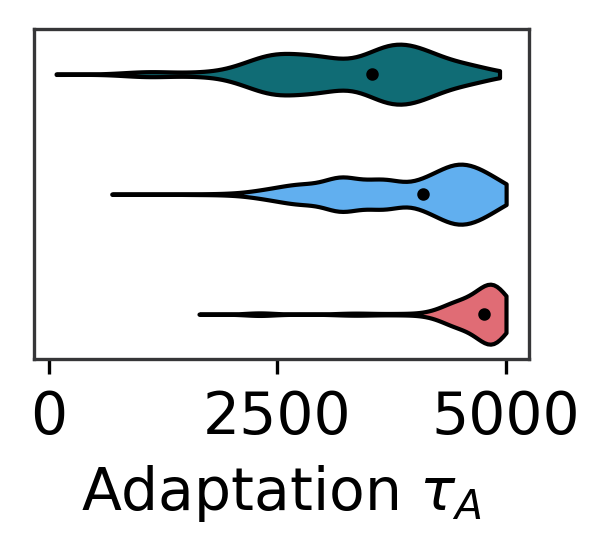

In [358]:
plot_evolution_violin(key="tauA", label="Adaptation $\\tau_A$", xticks=[0, 2500, 5000], savename="tau_distribution_eeg_mediankiller.pdf")

In [359]:
# plt.figure(figsize=(2, 1.75))
# plt.hist(dfGoodAll.tauA, density=True, edgecolor='k', linewidth=0.75, color='C1')
# plt.hist(dfGoodMedian.tauA, alpha=0.75, density=True, edgecolor='k', linewidth=0.75, color='C0')
# plt.yticks([])
# plt.ylabel("Density")
# plt.xlabel("Adaptation $\\tau_A$")
# plt.tight_layout()
# bp.set_axis_size(1.5, 1)
# plt.savefig("/Users/caglar/Documents/PhD/papers/2020-1-evolutionary-fitting/figures/assets/evolution/assets/tau_distribution_eeg_mediankiller.pdf", transparent=True)

In [360]:
#plot_evolution_histogram(key="Ke_gl", label="Global coupling $K$", savename="K_distribution_eeg_mediankiller.pdf")

In [361]:
# plt.figure(figsize=(2, 1.75))
# plt.hist(dfGoodAll.Ke_gl, density=True, edgecolor='k', linewidth=0.75, color='C1')
# plt.hist(dfGoodMedian.Ke_gl, alpha=0.75, density=True, edgecolor='k', linewidth=0.75, color='C0')
# plt.yticks([])
# #plt.ylabel("Density")
# plt.xlabel("Global coupling $K$")
# plt.tight_layout()
# bp.set_axis_size(1.5, 1)
# plt.savefig("/Users/caglar/Documents/PhD/papers/2020-1-evolutionary-fitting/figures/assets/evolution/assets/K_distribution_eeg_mediankiller.pdf", transparent=True)

[0, 1, 2, 3]
Medians: ('Mediankiller', 326.58663181204133) ('All', 288.56981722242926) ('fMRI (b=0)', 356.81750691612524) ('fMRI (b>0)', 284.5827976593778)
Maximums: ('Mediankiller', 394.04195065204243) ('All', 399.8706981852467) ('fMRI (b=0)', 398.5995001598928) ('fMRI (b>0)', 399.9699115556393)
Minimums: ('Mediankiller', 109.59497564405234) ('All', 100.03888175282876) ('fMRI (b=0)', 141.4625484101175) ('fMRI (b>0)', 100.52262405902714)


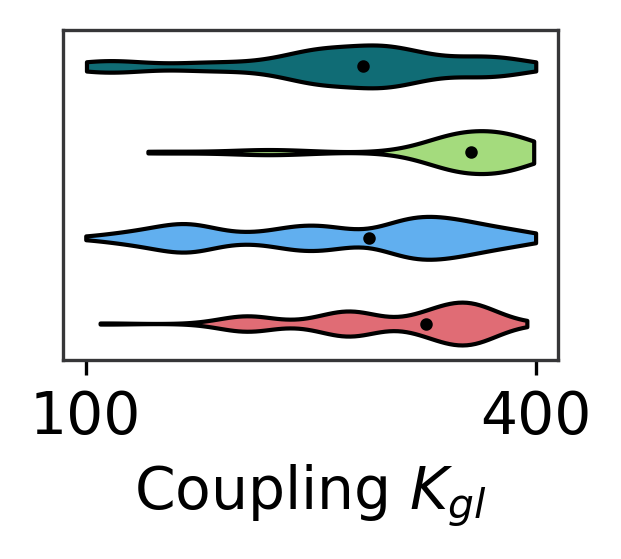

In [362]:
plot_evolution_violin(key="Ke_gl", label="Coupling $K_{gl}$", xticks=[100, 400], savename="K_distribution_eeg_mediankiller.pdf")